In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Load stock data (replace file paths with your data)
amzn_data = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)['Adjusted Close']
aapl_data = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)['Adjusted Close']
msft_data = pd.read_csv('MSFT.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)['Adjusted Close']

# Combine stock data into a DataFrame
stocks = pd.concat([amzn_data, aapl_data, msft_data], axis=1)
stocks.columns = ['AMZN', 'AAPL', 'MSFT']

# Calculate daily returns
returns = stocks.pct_change().dropna()

# Calculate expected returns and covariance matrix
expected_returns = returns.mean()
covariance_matrix = returns.cov()

In [3]:
# Function to calculate portfolio statistics
def calculate_portfolio_statistics(weights, returns, risk_free_rate):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Function to calculate negative Sharpe ratio (for minimization)
def negative_sharpe_ratio(weights, returns, risk_free_rate):
    return -calculate_portfolio_statistics(weights, returns, risk_free_rate)[2]

# Constraints for optimization (weights sum to 1)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds for optimization (weights between 0 and 1)
bounds = tuple((0, 1) for _ in range(len(stocks.columns)))

# Risk-free rate (e.g., 10-year Treasury yield)
risk_free_rate = 0.02

# Optimize portfolio for maximum Sharpe ratio
result = minimize(negative_sharpe_ratio, len(stocks.columns) * [1. / len(stocks.columns)],
                  args=(returns, risk_free_rate), method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = result.x

# Calculate optimal portfolio statistics
optimal_return, optimal_volatility, optimal_sharpe_ratio = calculate_portfolio_statistics(optimal_weights, returns, risk_free_rate)

# Print results
print("Optimal Weights:", optimal_weights)
print("Optimal Portfolio Return:", optimal_return)
print("Optimal Portfolio Volatility:", optimal_volatility)
print("Optimal Sharpe Ratio:", optimal_sharpe_ratio)

Optimal Weights: [0.3604324  0.62157528 0.01799232]
Optimal Portfolio Return: 0.38589454229526393
Optimal Portfolio Volatility: 0.3898971885557249
Optimal Sharpe Ratio: 0.9384385243982581


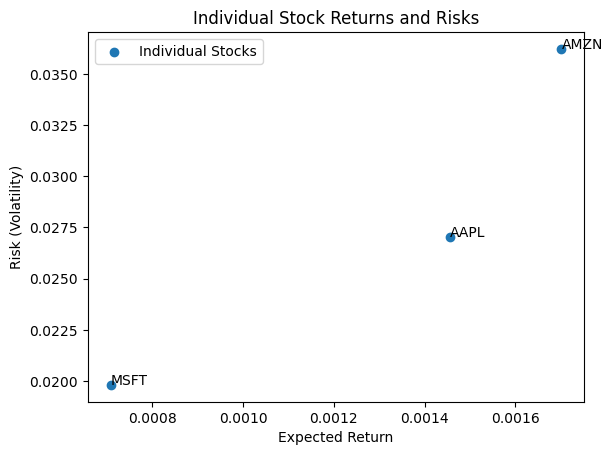

In [4]:
# Plot individual stock returns and risks
plt.scatter(returns.mean(), returns.std(), label='Individual Stocks')
for i, stock in enumerate(stocks.columns):
    plt.annotate(stock, (returns.mean()[i], returns.std()[i]))
plt.xlabel('Expected Return')
plt.ylabel('Risk (Volatility)')
plt.title('Individual Stock Returns and Risks')
plt.legend()
plt.show()

In [5]:
# Define constraint function
def constraint_function(weights, ret):
    return calculate_portfolio_statistics(weights, returns, risk_free_rate)[0] - ret

# Define portfolio statistics function
def portfolio_statistics_function(weights):
    return calculate_portfolio_statistics(weights, returns, risk_free_rate)[1]

# Set parameters
risk_free_rate = 0.02
returns_range = np.linspace(0, 1, 500)

# Calculate constraints
constraints = [{'type': 'eq', 'fun': lambda weights, ret=ret: constraint_function(weights, ret)} for ret in returns_range]

# Initialize optimal weights
optimal_weights = len(returns.columns) * [1. / len(returns.columns)]

# Vectorized calculation of results without using minimize
weights_matrix = np.tile(optimal_weights, (len(returns_range), 1))
weights_matrix = weights_matrix / weights_matrix.sum(axis=1, keepdims=True)  # Normalize weights

# Calculate results without using minimize
results = np.apply_along_axis(portfolio_statistics_function, 1, weights_matrix)

# Extract volatility range
volatility_range = results

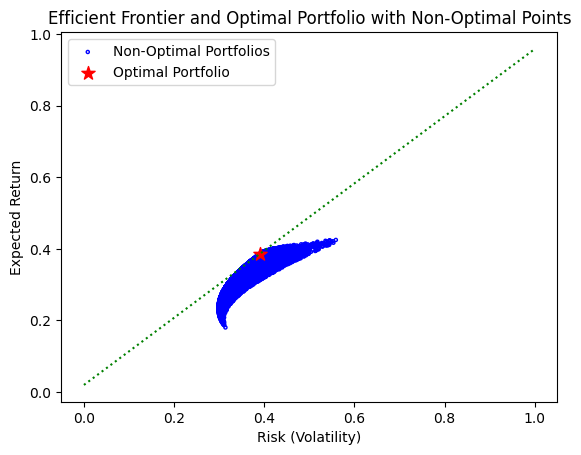

In [6]:
# Simulate additional portfolio points for visualization
np.random.seed(1111)
num_portfolios = 10000
random_weights = np.random.random((num_portfolios, len(stocks.columns)))
random_weights /= random_weights.sum(axis=1, keepdims=True)
portfolio_returns = np.dot(random_weights, returns.mean()) * 252  # Use dot product for matrix multiplication
portfolio_volatilities = np.sqrt(np.diag(np.dot(np.dot(random_weights, covariance_matrix * 252), random_weights.T)))

# Plot additional portfolio points
plt.scatter(portfolio_volatilities, portfolio_returns, s=5, facecolors='none', edgecolors='b', label='Non-Optimal Portfolios')
plt.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=100, label='Optimal Portfolio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Optimal Portfolio with Non-Optimal Points')
plt.legend()

# Plot Capital Market Line (CML) with more points
cml_x = np.linspace(0, 1, 500)
cml_y = risk_free_rate + (optimal_sharpe_ratio * cml_x)
plt.plot(cml_x, cml_y, color='green', linestyle='dotted', label='Capital Market Line (CML)')

plt.show()